In [2]:
!pip install internetarchive

  Obtaining dependency information for internetarchive from https://files.pythonhosted.org/packages/92/25/6488b4531f9719bfa786c954fff5de97b2a5b807e24dbcaa861fd00e0f1a/internetarchive-4.1.0-py3-none-any.whl.metadata
  Using cached docopt-0.6.2-py2.py3-none-any.whl
  Obtaining dependency information for jsonpatch>=0.4 from https://files.pythonhosted.org/packages/73/07/02e16ed01e04a374e644b575638ec7987ae846d25ad97bcc9945a3ee4b0e/jsonpatch-1.33-py2.py3-none-any.whl.metadata
  Obtaining dependency information for schema>=0.4.0 from https://files.pythonhosted.org/packages/ad/1b/81855a88c6db2b114d5b2e9f96339190d5ee4d1b981d217fa32127bb00e0/schema-0.7.7-py2.py3-none-any.whl.metadata
  Obtaining dependency information for importlib-metadata>=3.6.0 from https://files.pythonhosted.org/packages/a0/d9/a1e041c5e7caa9a05c925f4bdbdfb7f006d1f74996af53467bc394c97be7/importlib_metadata-8.5.0-py3-none-any.whl.metadata
  Obtaining dependency information for zipp>=3.20 from https://files.pythonhosted.org/pac

In [3]:
import pandas as pd
from internetarchive import get_item, download, search_items


In [2]:
def download_books(author):
    q=author

    #download books from internet archive
    search="creator:(\""+q+"\")& mediatype:(texts) &language:(eng)" #restrict to english books

    results = search_items(search, fields=["title", "creator", "year", "subject"])
    #other metadata fields are available, see https://archive.org/advancedsearch.php

    ia_books=[] 
    count=0

    #loop through results and download
    for r in results:
        if count>10:
            break
        
        if "year" not in r:
            year=0
        else:
            year=int(r["year"])
        author=r["creator"]
        try:
            download(r["identifier"], verbose=False, glob_pattern='*txt', destdir="book/")
        except:
            continue
        ia_books.append([r["identifier"], r["title"], author,year])
        count+=1
    #convert to dataframe

    df=pd.DataFrame(ia_books, columns=["identifier", "title", "author", "year"])

    #and save
    df.to_csv(q+".csv", index=False)

In [ ]:
download_books("Charles Dickens")

In [3]:
download_books("Paul Laurence Dunbar")

In [4]:
download_books("Charles Darwin")

In [4]:
#read and combine author data
df1=pd.read_csv("Paul Laurence Dunbar.csv")
df2=pd.read_csv("Charles Darwin.csv")
df3=pd.read_csv("Charles Dickens.csv")

df1["author"]="Paul Laurence Dunbar"
df2["author"]="Charles Darwin"
df3["author"]="Charles Dickens"
df=pd.concat([df1, df2, df3])

df.head()

,identifier,title,author,year
0,TheMortificationOfTheFlesh,The Mortification Of The Flesh,Paul Laurence Dunbar,1906
1,completepoemsofp0000paul,THE COMPLETE POEMS OF PAUL LAURENCE DUNBAR Wit...,Paul Laurence Dunbar,1916
2,fanatics0000paul,The Fanatics,Paul Laurence Dunbar,1901
3,folksfromdixie0000unse_h5i3,FOLKS FROM DIXIE.,Paul Laurence Dunbar,1898
4,inoldplantationd0000paul,in old plantation days,Paul Laurence Dunbar,1903


In [5]:
#this is a function that does some light cleaning, by removing newline characters, converting to lowercase, and removing punctuation

def clean(text):
    #remove newline and space characters
    text = ' '.join(text.split())
    #convert the text to lowercase
    text = text.lower()
    #remove punctuation
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    return text

In [6]:
texts=[]
import glob
for id in df["identifier"]:
    path=glob.glob('book/'+id+'/*djvu.txt')
    try:
        f = open(path[0], "r", encoding="utf-8")
        text=f.read()
        f.close()
    except:
        continue
    text=clean(text)
    texts.append(text)

df["text"]=texts

In [8]:
# convert texts to a bag of words representation

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=2, max_df=0.8, stop_words='english')

X = vectorizer.fit_transform(df["text"])

#convert to a dataframe


#replace with get_feature_names_out() if you get an error
df_bow=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())





Placing points in space lets us see the relationship between points

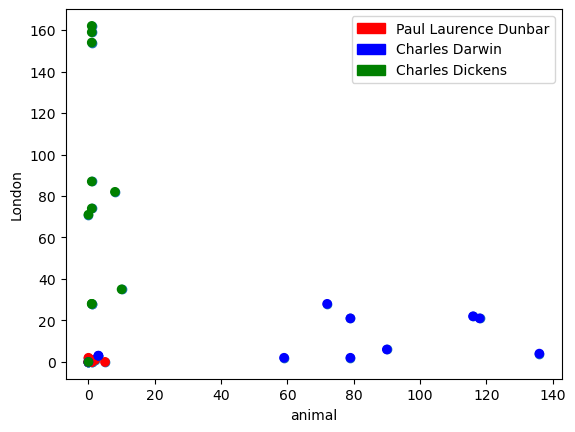

In [9]:
#let's look at two words and plot the dimensions

import matplotlib.pyplot as plt

plt.scatter(df_bow["animal"], df_bow["london"])

plt.xlabel("animal")

plt.ylabel("London")

#color by author

colors = {'Paul Laurence Dunbar':'red', 'Charles Darwin':'blue', 'Charles Dickens':'green'}

plt.scatter(df_bow["animal"], df_bow["london"], c=df["author"].apply(lambda x: colors[x]))

#add a legend

import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Paul Laurence Dunbar')

blue_patch = mpatches.Patch(color='blue', label='Charles Darwin')

green_patch = mpatches.Patch(color='green', label='Charles Dickens')

plt.legend(handles=[red_patch, blue_patch, green_patch])

plt.show()


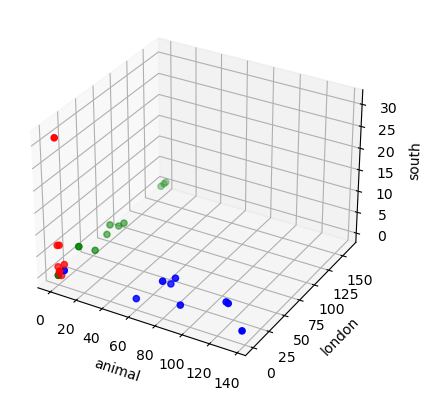

In [15]:
#make 3d plot with three words

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_bow["animal"], df_bow["london"], df_bow["dawn"], c=df["author"].apply(lambda x: colors[x]))

ax.set_xlabel('animal')

ax.set_ylabel('london')

ax.set_zlabel('south')

plt.show()




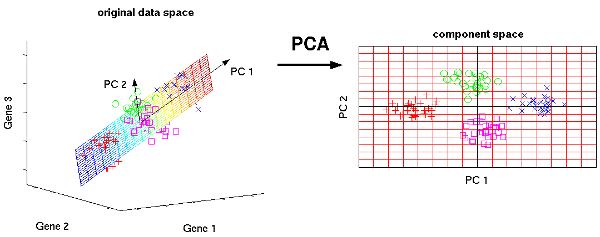

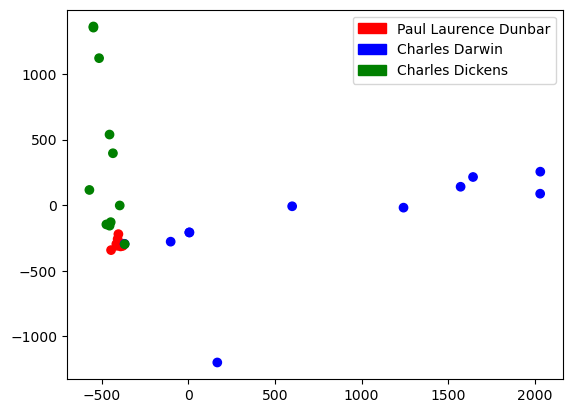

In [16]:
# but there's no reason we can't consider all the words in the bag of words representation

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(df_bow)

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])


plt.scatter(principalDf["principal component 1"], principalDf["principal component 2"], c=df["author"].apply(lambda x: colors[x]))


ax.set_xlabel('Principal Component 1', fontsize = 15)

ax.set_ylabel('Principal Component 2', fontsize = 15)

ax.set_title('2 component PCA', fontsize = 20)
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='Paul Laurence Dunbar')

blue_patch = mpatches.Patch(color='blue', label='Charles Darwin')

green_patch = mpatches.Patch(color='green', label='Charles Dickens')

plt.legend(handles=[red_patch, blue_patch, green_patch])

plt.show()


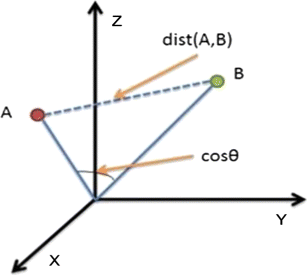

In [53]:

v1=df_bow.iloc[0].values.reshape(1, -1)

v2=df_bow.iloc[1].values.reshape(1, -1)

In [70]:
df.head(2)

,identifier,title,author,year,text
0,TheMortificationOfTheFlesh,The Mortification Of The Flesh,Paul Laurence Dunbar,1906,los angeles herald sunday supplement the morti...
1,completepoemsofp0000paul,THE COMPLETE POEMS OF PAUL LAURENCE DUNBAR Wit...,Paul Laurence Dunbar,1916,a hi ni iitlet ae a aea an hi v any tie cane...


In [54]:
#euclidean distance

from sklearn.metrics.pairwise import euclidean_distances

euclidean_distances(v1, v2)


array([[6258.9428021]])

In [76]:
len(df["text"].iloc[0])

33930

In [77]:
len(df["text"].iloc[1])

449220

In [63]:
cosine_similarity(v1, v2)

array([[0.85734752]])

In [61]:
#calculate distance between two books

from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(df_bow.iloc[0].values.reshape(1, -1), df_bow.iloc[1].values.reshape(1, -1))

#calculate distance between all books

cosine_similarities = cosine_similarity(df_bow)

#merge with metadata

df_sim=pd.DataFrame(cosine_similarities, columns=df["title"], index=df["title"])

df_sim.head(10)


title,The Mortification Of The Flesh,THE COMPLETE POEMS OF PAUL LAURENCE DUNBAR With an Introduction by W. D. Howells,The Fanatics,FOLKS FROM DIXIE.,in old plantation days,Joggin' Erlong,Lyrics of the hearthside,Lyrics of Lowly Life,The Uncalled,Insectivorous plants,...,A Child's History of England (Google eBook) Volume III,"A Child's History of England, 2 (Google eBook)",A Child's History of England.No Thoroughfare (Google eBook),The Works of Charles Dickens: A child's history of England. No thoroughfare (Google eBook),The Works of Charles Dickens ...: A child's history of England (Google eBook),"The Posthumous Papers of the Pickwick Club: Containing a Faithful Record of the Perambulations, Perils, Travels, Adventures and Sporting Transactions of the Corresponding Members, Volume 1 (Google eBook)",Bleak House By Charles Dickens Pg 1023,"Talk by Chas. D. Lewis, Assistant Director, Northeast Division, Agricultural Adjustment Administration, before potato growers at Orono, Maine, during Farm Home Week, on March 30, 1938.",Dickens Great Expectations,Major Works
title,,,,,,,,,,,,,,,,,,,,,
The Mortification Of The Flesh,1.000000,0.857348,0.944380,0.946414,0.943094,0.428837,0.853985,0.890350,0.963256,0.806840,...,0.918624,0.916231,0.929538,0.929606,0.915545,0.910232,0.925600,0.836809,0.928077,0.944322
THE COMPLETE POEMS OF PAUL LAURENCE DUNBAR With an Introduction by W. D. Howells,0.857348,1.000000,0.873774,0.923792,0.909622,0.660285,0.987669,0.958508,0.886284,0.782853,...,0.838505,0.841844,0.858760,0.858990,0.841673,0.851980,0.878544,0.797422,0.865737,0.877107
The Fanatics,0.944380,0.873774,1.000000,0.954423,0.966718,0.371481,0.862536,0.918707,0.976321,0.842246,...,0.960028,0.960260,0.969072,0.969401,0.959834,0.946915,0.951684,0.856267,0.954943,0.980800
FOLKS FROM DIXIE.,0.946414,0.923792,0.954423,1.000000,0.982518,0.552579,0.919590,0.929704,0.969425,0.810583,...,0.921168,0.920542,0.931743,0.932125,0.919270,0.916021,0.927953,0.824152,0.931390,0.946474
in old plantation days,0.943094,0.909622,0.966718,0.982518,1.000000,0.516084,0.899745,0.923284,0.972893,0.795972,...,0.931997,0.931701,0.939994,0.940540,0.929241,0.918967,0.937618,0.817110,0.942478,0.954646
Joggin' Erlong,0.428837,0.660285,0.371481,0.552579,0.516084,1.000000,0.666730,0.507745,0.429929,0.250350,...,0.312315,0.311053,0.328083,0.328627,0.307129,0.326833,0.411946,0.290163,0.393894,0.360026
Lyrics of the hearthside,0.853985,0.987669,0.862536,0.919590,0.899745,0.666730,1.000000,0.949875,0.879499,0.778130,...,0.826847,0.829579,0.847730,0.847851,0.829946,0.841135,0.868478,0.785958,0.854424,0.864680
Lyrics of Lowly Life,0.890350,0.958508,0.918707,0.929704,0.923284,0.507745,0.949875,1.000000,0.920822,0.831787,...,0.897557,0.900730,0.912777,0.912991,0.900209,0.898986,0.916438,0.836518,0.908512,0.926235
The Uncalled,0.963256,0.886284,0.976321,0.969425,0.972893,0.429929,0.879499,0.920822,1.000000,0.815929,...,0.939332,0.938181,0.949620,0.949935,0.936616,0.929712,0.952113,0.845543,0.952275,0.968041


In [86]:
#get most similar books to a given book
#get first column of the dataframe

df_sim["The variation of animals and plants under domestication"].iloc[:,0].sort_values(ascending=False)



title
The variation of animals and plants under domestication                                                                                                                                                        1.000000
The Descent of Man, and Selection in Relation to Sex, Volume 1 (Google eBook)                                                                                                                                  0.985050
The Variation of Animals and Plants Under Domestication, Volume 2 (Google eBook)                                                                                                                               0.976052
The variation of animals and plants under domestication                                                                                                                                                        0.975607
The Expression of the Emotions in Man and Animals                                                                                 

<Axes: xlabel='title', ylabel='title'>

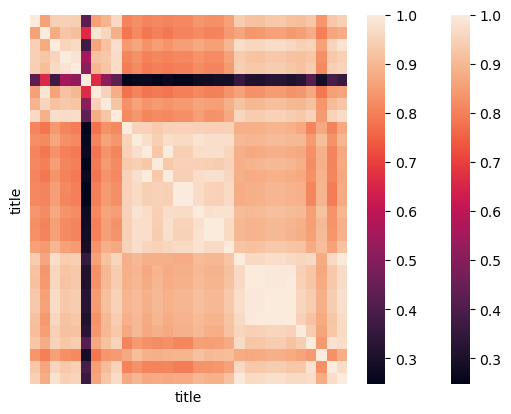

In [62]:
#plot heatmap

import seaborn as sns

sns.heatmap(df_sim)
#no labels
#add color bar for rows and columns

sns.heatmap(df_sim, xticklabels=False, yticklabels=False,)

